# Imports

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Prepare Data

In [19]:
test = pd.read_csv('data/nba_boxscores_2020-21.csv')

In [20]:
test

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,playerSlug,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,estimatedOffensiveRating,offensiveRating,estimatedDefensiveRating,defensiveRating,estimatedNetRating,netRating,assistPercentage,assistToTurnover,assistRatio,offensiveReboundPercentage,defensiveReboundPercentage,reboundPercentage,turnoverRatio,effectiveFieldGoalPercentage,trueShootingPercentage,usagePercentage,estimatedUsagePercentage,estimatedPace,pace,pacePer40,possessions,PIE,gameMin,team_fieldGoalsMade,team_fieldGoalsAttempted,team_fieldGoalsPercentage,team_threePointersMade,team_threePointersAttempted,team_threePointersPercentage,team_freeThrowsMade,team_freeThrowsAttempted,team_freeThrowsPercentage,team_reboundsOffensive,team_reboundsDefensive,team_reboundsTotal,team_assists,team_steals,team_blocks,team_turnovers,team_foulsPersonal,team_points,team_plusMinusPoints,team_estimatedOffensiveRating,team_offensiveRating,team_estimatedDefensiveRating,team_defensiveRating,team_estimatedNetRating,team_netRating,team_assistPercentage,team_assistToTurnover,team_assistRatio,team_offensiveReboundPercentage,team_defensiveReboundPercentage,team_reboundPercentage,team_estimatedTeamTurnoverPercentage,team_turnoverRatio,team_effectiveFieldGoalPercentage,team_trueShootingPercentage,team_usagePercentage,team_estimatedUsagePercentage,team_estimatedPace,team_pace,team_pacePer40,team_possessions,team_PIE,home,won,opp_teamCity,opp_teamName,opp_teamTricode,opp_teamSlug,opp_fieldGoalsMade,opp_fieldGoalsAttempted,opp_fieldGoalsPercentage,opp_threePointersMade,opp_threePointersAttempted,opp_threePointersPercentage,opp_freeThrowsMade,opp_freeThrowsAttempted,opp_freeThrowsPercentage,opp_reboundsOffensive,opp_reboundsDefensive,opp_reboundsTotal,opp_assists,opp_steals,opp_blocks,opp_turnovers,opp_foulsPersonal,opp_points,opp_plusMinusPoints,opp_estimatedOffensiveRating,opp_offensiveRating,opp_estimatedDefensiveRating,opp_defensiveRating,opp_estimatedNetRating,opp_netRating,opp_assistPercentage,opp_assistToTurnover,opp_assistRatio,opp_offensiveReboundPercentage,opp_defensiveReboundPercentage,opp_reboundPercentage,opp_estimatedTeamTurnoverPercentage,opp_turnoverRatio,opp_effectiveFieldGoalPercentage,opp_trueShootingPercentage,opp_usagePercentage,opp_estimatedUsagePercentage,opp_estimatedPace,opp_pace,opp_pacePer40,opp_possessions,opp_PIE,gameDate
0,22000002,1610612746,LA,Clippers,LAC,clippers,202695,Kawhi,Leonard,K. Leonard,kawhi-leonard,F,NaN,NaN,34:00,10,26,0.385,1,8,0.125,5,5,1.0,0,2,2,3,2,0,3,5,26,1.0,113.1,117.8,109.6,113.3,3.5,4.5,0.136,1.0,8.8,0.000,0.069,0.030,8.8,0.404,0.461,0.365,0.360,108.42,104.47,87.05,73.0,0.069,240:00,44,93,0.473,14,40,0.350,14,19,0.737,11,29,40,22,10,3,16,29,116,7.0,109.1,111.5,103.2,104.8,5.9,6.7,0.500,1.38,15.8,0.269,0.750,0.490,15.043,15.4,0.548,0.572,1.0,0.198,106.00,104.0,86.67,104.0,0.491,False,True,Los Angeles,Lakers,LAL,lakers,38,81,0.469,9,29,0.310,24,31,0.774,8,37,45,22,4,2,19,20,109,-7.0,103.2,104.8,109.1,111.5,-5.9,-6.7,0.579,1.16,16.2,0.250,0.731,0.510,17.986,18.3,0.525,0.576,1.0,0.199,106.00,104.0,86.67,104.0,0.509,2020-12-22
1,22000002,1610612746,LA,Clippers,LAC,clippers,201587,Nicolas,Batum,N. Batum,nicolas-batum,F,NaN,NaN,28:10,1,4,0.250,1,3,0.333,0,0,0.0,1,5,6,6,2,0,1,2,3,-2.0,110.8,116.7,118.8,120.0,-8.0,-3.3,0.240,6.0,54.5,0.031,0.227,0.111,9.1,0.375,0.375,0.071,0.070,105.45,102.24,85.20,60.0,0.093,240:00,44,93,0.473,14,40,0.350,14,19,0.737,11,29,40,22,10,3,16,29,116,7.0,109.1,111.5,103.2,104.8,5.9,6.7,0.500,1.38,15.8,0.269,0.750,0.490,15.043,15.4,0.548,0.572,1.0,0.198,106.00,104.0,86.67,104.0,0.491,False,True,Los Angeles,Lakers,LAL,lakers,38,81,0.469,9,29,0.310,24,31,0.774,8,37,

In [3]:
# Load data
seasons = ['2024-25', '2023-24', '2022-23', '2021-22', '2020-21']
data_frames = []

for season in seasons:
    df = pd.read_csv(f'data/nba_boxscores_{season}.csv')
    data_frames.append(df)

data = pd.concat(data_frames, ignore_index=True)

In [4]:
# Sort data based on player and game date
data['gameDate'] = pd.to_datetime(data['gameDate'])

data = data.sort_values('gameDate').reset_index(drop=True)

In [5]:
# Add seconds column
def parse_minutes_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    try:
        # Split by colon
        minutes_part, seconds_part = str(time_str).split(':')
        # Convert minute to float, in case it's like "36.000000"
        minutes = float(minutes_part)
        seconds = int(seconds_part)
        total_seconds = int(minutes * 60 + seconds)
        return total_seconds
    except:
        return None  # if formatting fails
    
data['seconds'] = data['minutes'].apply(parse_minutes_to_seconds)


In [6]:
# Drop rows where player didn't play
data = data[data['seconds'] > 0]

# Feature Engineering

In [ ]:
def player_rolling_5(stat):
    data[f'{stat}_rolling_5'] = (
        data.groupby('playerSlug')[stat]
            .transform(lambda x: x.shift().rolling(window=5).mean())
    )

player_stats = ['seconds', 'fieldGoalsAttempted', 'freeThrowsAttempted', 'points', 'offensiveRating', 'turnoverRatio', 'trueShootingPercentage', 'usagePercentage', 'possessions']

for player_stat in player_stats:
    player_rolling_5(player_stat)

In [7]:
data

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,playerSlug,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,estimatedOffensiveRating,offensiveRating,estimatedDefensiveRating,defensiveRating,estimatedNetRating,netRating,assistPercentage,assistToTurnover,assistRatio,offensiveReboundPercentage,defensiveReboundPercentage,reboundPercentage,turnoverRatio,effectiveFieldGoalPercentage,trueShootingPercentage,usagePercentage,estimatedUsagePercentage,estimatedPace,pace,pacePer40,possessions,PIE,gameMin,team_fieldGoalsMade,team_fieldGoalsAttempted,team_fieldGoalsPercentage,team_threePointersMade,team_threePointersAttempted,team_threePointersPercentage,team_freeThrowsMade,team_freeThrowsAttempted,team_freeThrowsPercentage,team_reboundsOffensive,team_reboundsDefensive,team_reboundsTotal,team_assists,team_steals,team_blocks,team_turnovers,team_foulsPersonal,team_points,team_plusMinusPoints,team_estimatedOffensiveRating,team_offensiveRating,team_estimatedDefensiveRating,team_defensiveRating,team_estimatedNetRating,team_netRating,team_assistPercentage,team_assistToTurnover,team_assistRatio,team_offensiveReboundPercentage,team_defensiveReboundPercentage,team_reboundPercentage,team_estimatedTeamTurnoverPercentage,team_turnoverRatio,team_effectiveFieldGoalPercentage,team_trueShootingPercentage,team_usagePercentage,team_estimatedUsagePercentage,team_estimatedPace,team_pace,team_pacePer40,team_possessions,team_PIE,home,won,opp_teamCity,opp_teamName,opp_teamTricode,opp_teamSlug,opp_fieldGoalsMade,opp_fieldGoalsAttempted,opp_fieldGoalsPercentage,opp_threePointersMade,opp_threePointersAttempted,opp_threePointersPercentage,opp_freeThrowsMade,opp_freeThrowsAttempted,opp_freeThrowsPercentage,opp_reboundsOffensive,opp_reboundsDefensive,opp_reboundsTotal,opp_assists,opp_steals,opp_blocks,opp_turnovers,opp_foulsPersonal,opp_points,opp_plusMinusPoints,opp_estimatedOffensiveRating,opp_offensiveRating,opp_estimatedDefensiveRating,opp_defensiveRating,opp_estimatedNetRating,opp_netRating,opp_assistPercentage,opp_assistToTurnover,opp_assistRatio,opp_offensiveReboundPercentage,opp_defensiveReboundPercentage,opp_reboundPercentage,opp_estimatedTeamTurnoverPercentage,opp_turnoverRatio,opp_effectiveFieldGoalPercentage,opp_trueShootingPercentage,opp_usagePercentage,opp_estimatedUsagePercentage,opp_estimatedPace,opp_pace,opp_pacePer40,opp_possessions,opp_PIE,gameDate,seconds
0,22000001,1610612751,Brooklyn,Nets,BKN,nets,1628386,Jarrett,Allen,J. Allen,jarrett-allen,NaN,NaN,NaN,19:37,2,3,0.667,0,0,0.000,4,5,0.800,3,4,7,2,1,2,2,0,8,12.0,117.2,113.0,83.0,88.9,34.2,24.2,0.154,1.00,22.2,0.150,0.148,0.149,22.2,0.667,0.769,0.143,0.148,113.24,111.33,92.78,46.0,0.188,240:00,42,92,0.457,15,35,0.429,26,32,0.813,13,44,57,24,11,7,20,22,125,26.0,110.5,111.6,86.8,88.4,23.8,23.2,0.571,1.20,16.0,0.315,0.719,0.534,17.687,17.9,0.538,0.589,1.0,0.201,113.60,112.0,93.33,112.0,0.650,True,True,Golden State,Warriors,GSW,warriors,37,99,0.374,10,33,0.303,15,23,0.652,13,34,47,26,6,6,18,24,99,-26.0,86.8,88.4,110.5,111.6,-23.8,-23.2,0.703,1.44,17.0,0.281,0.685,0.466,15.773,16.1,0.424,0.454,1.0,0.201,113.60,112.0,93.33,112.0,0.350,2020-12-22,1177.0
1,22000001,1610612744,Golden State,Warriors,GSW,warriors,1629672,Eric,Paschall,E. Paschall,eric-paschall,F,NaN,NaN,21:33,2,6,0.333,1,1,1.000,1,2,0.500,1,0,1,0,0,1,0,1,6,-28.0,74.2,75.5,127.7,127.5,-53.4,-51.9,0.000,0.00,0.0,0.036,0.000,0.020,0.0,0.417,0.436,0.127,0.130,112.22,111.37,92.81,49.0,0.012,240:00,37,99,0.374,10,33,0.303,15,23,0.652,13,34,47,26,6,6,18,24,99,-26.0,86.8,88.4,110.5,111.6,-23.8,-23.2,0.703,1.44,17.0,0.281,0.685,0.466,15.773,16.1,0.424,0.454,1.0,0.201,113.60,112.0,93.33,112.0,0.350,False,False,Brooklyn,Nets,BKN,nets,42,

In [8]:
games = data.drop_duplicates(subset=['gameId', 'teamId'])
games = games[['gameId', 'teamId', 'team_defensiveRating', 'gameDate']]

In [9]:
games

,gameId,teamId,team_defensiveRating,gameDate
0,22000001,1610612751,88.4,2020-12-22
1,22000001,1610612744,111.6,2020-12-22
29,22000002,1610612747,111.5,2020-12-22
30,22000002,1610612746,104.8,2020-12-22
56,22000012,1610612748,105.6,2020-12-23
...,...,...,...,...
156538,22401197,1610612759,114.6,2025-04-13
156561,22401189,1610612739,99.2,2025-04-13
156576,22401199,1610612747,119.8,2025-04-13
156597,22401199,1610612757,89.0,2025-04-13


In [11]:
games['team_defensiveRating_rolling_5'] = (
    games.groupby('teamId')['team_defensiveRating']
        .transform(lambda x: x.shift().rolling(window=5).mean())
)

In [15]:
(88.4+96.9+102.9+105.5+129.4)/5

104.62

In [14]:
games[games['teamId'] == 1610612751].head(10)

,gameId,teamId,team_defensiveRating,gameDate,team_defensiveRating_rolling_5
0,22000001,1610612751,88.4,2020-12-22,NaN
392,22000007,1610612751,96.9,2020-12-25,NaN
1065,22000032,1610612751,102.9,2020-12-27,NaN
1209,22000042,1610612751,105.5,2020-12-28,NaN
1624,22000057,1610612751,129.4,2020-12-30,NaN
2060,22000072,1610612751,115.2,2021-01-01,104.62
2467,22000086,1610612751,112.8,2021-01-03,109.98
2779,22000102,1610612751,94.1,2021-01-05,113.16
3214,22000118,1610612751,99.1,2021-01-07,111.40
3466,22000128,1610612751,110.6,2021-01-08,110.12


In [17]:
data

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,playerSlug,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,estimatedOffensiveRating,offensiveRating,estimatedDefensiveRating,defensiveRating,estimatedNetRating,netRating,assistPercentage,assistToTurnover,assistRatio,offensiveReboundPercentage,defensiveReboundPercentage,reboundPercentage,turnoverRatio,effectiveFieldGoalPercentage,trueShootingPercentage,usagePercentage,estimatedUsagePercentage,estimatedPace,pace,pacePer40,possessions,PIE,gameMin,team_fieldGoalsMade,team_fieldGoalsAttempted,team_fieldGoalsPercentage,team_threePointersMade,team_threePointersAttempted,team_threePointersPercentage,team_freeThrowsMade,team_freeThrowsAttempted,team_freeThrowsPercentage,team_reboundsOffensive,team_reboundsDefensive,team_reboundsTotal,team_assists,team_steals,team_blocks,team_turnovers,team_foulsPersonal,team_points,team_plusMinusPoints,team_estimatedOffensiveRating,team_offensiveRating,team_estimatedDefensiveRating,team_defensiveRating,team_estimatedNetRating,team_netRating,team_assistPercentage,team_assistToTurnover,team_assistRatio,team_offensiveReboundPercentage,team_defensiveReboundPercentage,team_reboundPercentage,team_estimatedTeamTurnoverPercentage,team_turnoverRatio,team_effectiveFieldGoalPercentage,team_trueShootingPercentage,team_usagePercentage,team_estimatedUsagePercentage,team_estimatedPace,team_pace,team_pacePer40,team_possessions,team_PIE,home,won,opp_teamCity,opp_teamName,opp_teamTricode,opp_teamSlug,opp_fieldGoalsMade,opp_fieldGoalsAttempted,opp_fieldGoalsPercentage,opp_threePointersMade,opp_threePointersAttempted,opp_threePointersPercentage,opp_freeThrowsMade,opp_freeThrowsAttempted,opp_freeThrowsPercentage,opp_reboundsOffensive,opp_reboundsDefensive,opp_reboundsTotal,opp_assists,opp_steals,opp_blocks,opp_turnovers,opp_foulsPersonal,opp_points,opp_plusMinusPoints,opp_estimatedOffensiveRating,opp_offensiveRating,opp_estimatedDefensiveRating,opp_defensiveRating,opp_estimatedNetRating,opp_netRating,opp_assistPercentage,opp_assistToTurnover,opp_assistRatio,opp_offensiveReboundPercentage,opp_defensiveReboundPercentage,opp_reboundPercentage,opp_estimatedTeamTurnoverPercentage,opp_turnoverRatio,opp_effectiveFieldGoalPercentage,opp_trueShootingPercentage,opp_usagePercentage,opp_estimatedUsagePercentage,opp_estimatedPace,opp_pace,opp_pacePer40,opp_possessions,opp_PIE,gameDate,seconds
0,22000001,1610612751,Brooklyn,Nets,BKN,nets,1628386,Jarrett,Allen,J. Allen,jarrett-allen,NaN,NaN,NaN,19:37,2,3,0.667,0,0,0.000,4,5,0.800,3,4,7,2,1,2,2,0,8,12.0,117.2,113.0,83.0,88.9,34.2,24.2,0.154,1.00,22.2,0.150,0.148,0.149,22.2,0.667,0.769,0.143,0.148,113.24,111.33,92.78,46.0,0.188,240:00,42,92,0.457,15,35,0.429,26,32,0.813,13,44,57,24,11,7,20,22,125,26.0,110.5,111.6,86.8,88.4,23.8,23.2,0.571,1.20,16.0,0.315,0.719,0.534,17.687,17.9,0.538,0.589,1.0,0.201,113.60,112.0,93.33,112.0,0.650,True,True,Golden State,Warriors,GSW,warriors,37,99,0.374,10,33,0.303,15,23,0.652,13,34,47,26,6,6,18,24,99,-26.0,86.8,88.4,110.5,111.6,-23.8,-23.2,0.703,1.44,17.0,0.281,0.685,0.466,15.773,16.1,0.424,0.454,1.0,0.201,113.60,112.0,93.33,112.0,0.350,2020-12-22,1177.0
1,22000001,1610612744,Golden State,Warriors,GSW,warriors,1629672,Eric,Paschall,E. Paschall,eric-paschall,F,NaN,NaN,21:33,2,6,0.333,1,1,1.000,1,2,0.500,1,0,1,0,0,1,0,1,6,-28.0,74.2,75.5,127.7,127.5,-53.4,-51.9,0.000,0.00,0.0,0.036,0.000,0.020,0.0,0.417,0.436,0.127,0.130,112.22,111.37,92.81,49.0,0.012,240:00,37,99,0.374,10,33,0.303,15,23,0.652,13,34,47,26,6,6,18,24,99,-26.0,86.8,88.4,110.5,111.6,-23.8,-23.2,0.703,1.44,17.0,0.281,0.685,0.466,15.773,16.1,0.424,0.454,1.0,0.201,113.60,112.0,93.33,112.0,0.350,False,False,Brooklyn,Nets,BKN,nets,42,

In [16]:
merged_df = pd.merge(
    data,
    games,
    left_on=['gameId', 'opp_teamId'],
    right_on=['gameId', 'teamId'],
    how='left'
)

KeyError: 'opp_teamId'

# Model

Test RMSE: 6.64 points


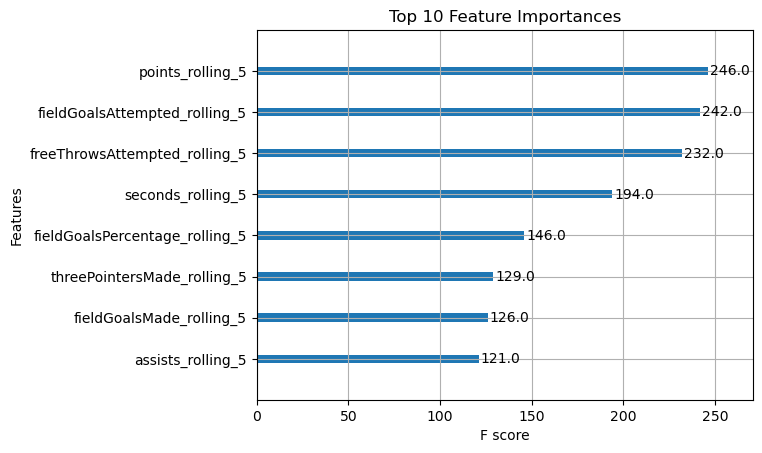

In [18]:
# Select feature to predict
target = "points"

# Select features to train on
features = [
    "points_rolling_5",
    "fieldGoalsMade_rolling_5",
    "fieldGoalsPercentage_rolling_5",
    "seconds_rolling_5",
    "fieldGoalsAttempted_rolling_5",
    "threePointersMade_rolling_5",
    "freeThrowsAttempted_rolling_5",
    "assists_rolling_5"
]

# Drop rows with missing data (or impute if you prefer)
data = data.dropna(subset=features + [target])

# Split into features (X) and target (y)
X = data[features]
y = data[target]

# Split train/test by time order to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Train the XGBoost Regressor
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.2f} points")

# Plot Feature Importance
plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()